In [1]:
import duckdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

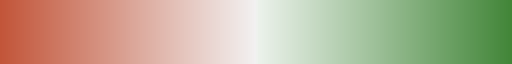

In [3]:
sns.set_theme()
sns.set_style('ticks', {"axes.grid": True})
sns.set_context('talk')
hm_w = 7.5
hm_h = 2.75
set_title = False
my_cmap = sns.diverging_palette(20, 125, as_cmap=True)
my_cmap

In [4]:
my_palette = sns.diverging_palette(20, 125)
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

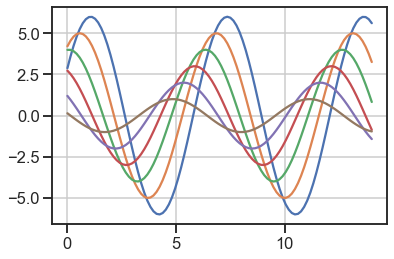

In [5]:
x = np.linspace(0, 14, 100)
for i in range(1, 7):
    plt.plot(x, np.sin(x + i * .5) * (7 - i) * 1)

In [6]:
con = duckdb.connect()
grouping_cols = ['count', 'columns', 'col_width', 'category']

# Functions

In [7]:
def load_csv(con, csv_path, median_cols):
    q = "select "
    q += ", ".join(grouping_cols)
    q += ", " + ", ".join([f"median({c}) as {c}" for c in median_cols])
    q += f" from read_csv_auto('{csv_path}') "
    q += "group by " + ", ".join(grouping_cols)
    q += " order by " + ", ".join(grouping_cols)
    con.execute(q)
    return con.fetchdf()

In [8]:
def compute_relative_runtime(con, df, cat1, cat2, col):
    q = "select\n\tcast(log2(c1.count) as int) as row_count,"
    q += f"\n\tc1.columns,\n\tc1.col_width,\n\tc1.{col} as {cat1}_{col},\n\tc2.{col} as {cat2}_{col},"
    q += f"\n\tround(c1.{col} / c2.{col}, 2) as relative_runtime"
    q += f"\nfrom\n\tdf c1,\n\tdf c2"
    q += f"\nwhere\n\tc1.category = '{cat1}'\nand\tc2.category = '{cat2}'\nand\t"
    q += "\nand\t".join([f"c1.{c} = c2.{c}" for c in grouping_cols[:-1]])
    q += "\norder by\n\trow_count,\n\t"
    q += ",\n\t".join([f"c1.{c}" for c in grouping_cols[1:-1]])
    con.execute(q)
    return con.fetchdf()

In [9]:
def create_heatmap(df, columns, title, fname):
    fig, ax = plt.subplots(figsize=(hm_w, hm_h))
    g = sns.heatmap(df.pivot(columns[0], columns[1], columns[2]), linewidths=0, center=1, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True, cbar=False)
    g.invert_yaxis()
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    if set_title:
        plt.title(f'Relative runtime of {title}')
    ax.set_xlabel('rows')
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

# Reordering

In [10]:
reorder_df = load_csv(con, 'results/reorder.csv', ['total', 'reorder', 'scatter', 'gather'])
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,120132540.0
1,row,269120417.0


In [11]:
reorder_total_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_total_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.413611,0.43


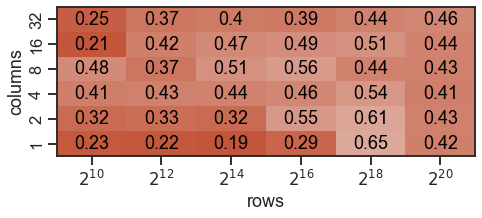

In [12]:
create_heatmap(reorder_total_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (incl. scatter + gather)',
               'reorder_incl_sg')

In [13]:
reorder_only_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'reorder')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_only_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.321944,1.365


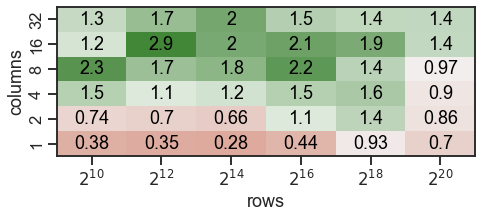

In [14]:
create_heatmap(reorder_only_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (excl. scatter + gather)',
               'reorder_excl_sg')

In [15]:
con.execute("""
    select
        cast(log2(count) as int) as row_count,
        columns,
        col_width,
        reorder as "row reorder",
        round(cast(scatter + gather as double) / total, 2) as sg
    from
        reorder_df
    where
        category = 'row'
    order by
        row_count asc,
        columns asc
""")
reorder_percentage_df = con.fetchdf()
con.execute('select avg(sg), median(sg) from reorder_percentage_df')
con.fetchdf()

,avg(sg),median(sg)
0,0.614444,0.665


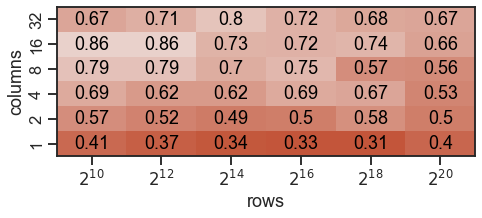

In [16]:
create_heatmap(reorder_percentage_df,
               ['columns', 'row_count', 'sg'],
               'scatter + gather as percentage of reorder runtime',
               'reorder_sg_percentage')

# Comparator

In [71]:
comparator_df = load_csv(con, 'results/comparator.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,841118922.0
1,col_branchless,935472249.0
2,col_ss,264150960.0
3,row_all,565815625.0
4,row_all_branchless,467124919.0
5,row_iter,236435292.0
6,row_norm,302052581.0


In [72]:
comparator_col_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'col_ss', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.309444,2.245


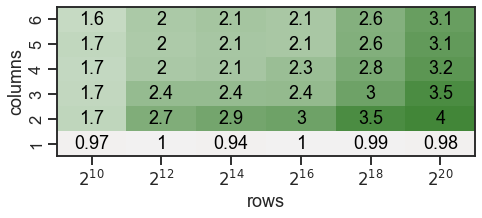

In [19]:
create_heatmap(comparator_col_iter_df,
               ['columns', 'row_count', 'relative_runtime'],
               'columnar_iterative vs. columnar_all (pdqsort)',
               'comparator_col_iter')

In [20]:
comparator_row_all_df = compute_relative_runtime(con, comparator_df, 'col', 'row_all', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_all_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.219167,1.215


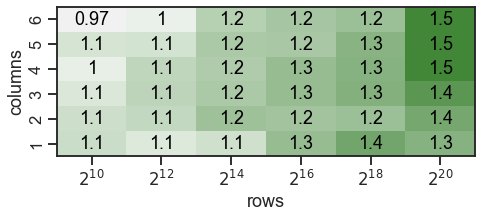

In [21]:
create_heatmap(comparator_row_all_df,
               ['columns', 'row_count', 'relative_runtime'],
               'row_all vs. columnar_iterative (pdqsort)',
               'comparator_row_all')

In [22]:
comparator_row_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'row_iter', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.409444,2.27


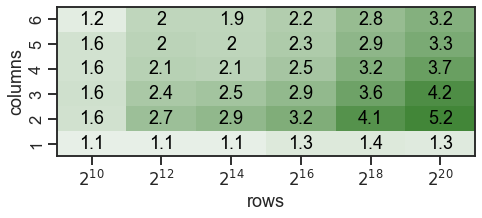

In [23]:
create_heatmap(comparator_row_iter_df,
               ['columns', 'row_count', 'relative_runtime'],
               'row_iter vs. columnar_iterative (pdqsort)',
               'comparator_row_iter')

In [24]:
comparator_norm_key_df = compute_relative_runtime(con, comparator_df, 'col', 'row_norm', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_norm_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.169722,2.26


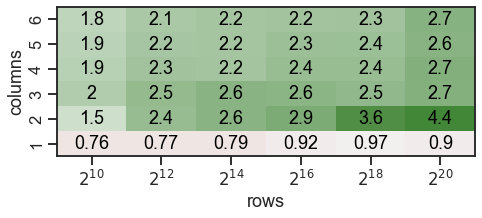

In [25]:
create_heatmap(comparator_norm_key_df,
               ['columns', 'row_count', 'relative_runtime'],
               'normalized_key vs. columnar_iterative (pdqsort)',
               'comparator_norm_key')

# Sort

In [26]:
sort_df = load_csv(con, 'results/sort.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_dynamic,551366791.0
1,pdq_static,274516621.0
2,radix,309688916.0


In [27]:
sort_static_radix_df = compute_relative_runtime(con, sort_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_static_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.850556,0.88


In [28]:
con.execute("select * from sort_static_radix_df where columns = 1")
con.fetchdf()

,row_count,columns,col_width,pdq_static_sort,radix_sort,relative_runtime
0,10,1,4,43417.0,38709.0,1.12
1,12,1,4,97250.0,124583.0,0.78
2,14,1,4,211583.0,342833.0,0.62
3,16,1,4,525291.0,958375.0,0.55
4,18,1,4,2141500.0,3847916.0,0.56
5,20,1,4,8438583.0,15656459.0,0.54


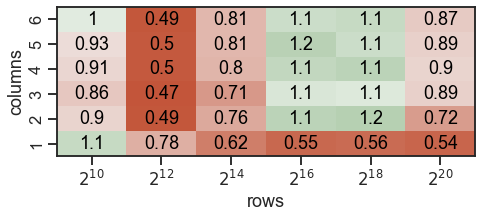

In [29]:
create_heatmap(sort_static_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_static vs. radix',
               'sort_static')

In [30]:
sort_dynamic_radix_df = compute_relative_runtime(con, sort_df, 'pdq_dynamic', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_dynamic_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.948333,1.59


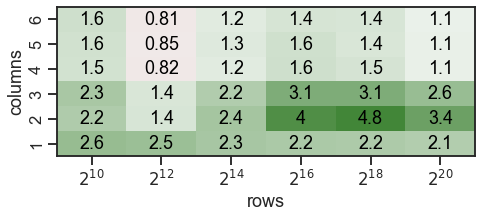

In [31]:
create_heatmap(sort_dynamic_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_dynamic vs. radix',
               'sort_dynamic')

In [32]:
con.execute("""
select category, count, columns, col_width, total
from sort_df
where category = 'radix'
union all
select category, count, columns, col_width, total
from comparator_df
where category = 'col_ss'
""")
col_ss_radix_df = con.fetchdf()

col_ss_radix_df = compute_relative_runtime(con, col_ss_radix_df, 'col_ss', 'radix', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from col_ss_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.750278,0.76


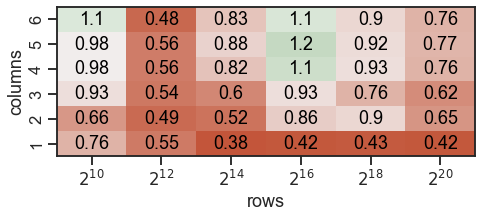

In [33]:
create_heatmap(col_ss_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'columnar_iterative vs. radix',
               'col_ss_radix')

# Merge Key

In [34]:
merge_key_df = load_csv(con, 'results/merge_key.csv', ['total'])
con.execute("select category, sum(total) from merge_key_df group by category")
con.fetchdf()

,category,sum(total)
0,col,411297702.0
1,row,160395588.0


In [35]:
merge_key_runtime = compute_relative_runtime(con, merge_key_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_runtime")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,3.072143,3.355


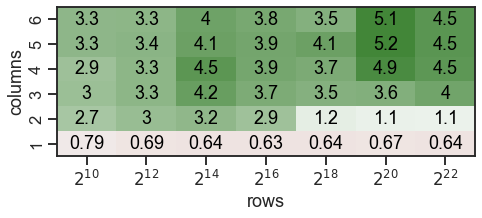

In [36]:
create_heatmap(merge_key_runtime,
               ['columns', 'row_count', 'relative_runtime'],
               'merge normalized key vs. merge key columnar',
               'merge_key')

# Merge Payload

In [37]:
merge_payload_df = load_csv(con, 'results/merge_payload.csv', ['total'])
con.execute("select category, sum(total) from merge_payload_df group by category")
con.fetchdf()

,category,sum(total)
0,col,436260252.0
1,row,288919462.0


In [38]:
merge_payload_runtime_df = compute_relative_runtime(con, merge_payload_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_payload_runtime_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.532857,1.425


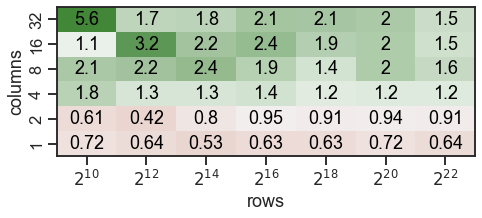

In [39]:
create_heatmap(merge_payload_runtime_df,
               ['columns', 'row_count', 'relative_runtime'],
               'merging rows vs. merging columns',
               'merge_payload')

# Static vs. Dynamic

In [40]:
mem_colors = [my_palette[0], my_palette[5]]

In [41]:
con.execute("""
select 'memcpy' as function, * from read_csv_auto('results/memcpy.csv')
union all
select 'memcmp' as function, * from read_csv_auto('results/memcmp.csv')
""")
mem_df = con.fetchdf()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


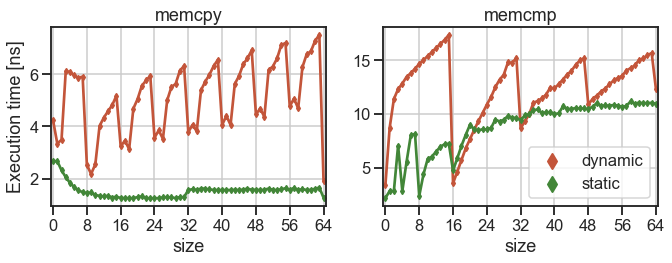

In [42]:
with plt.rc_context({'lines.linewidth': 1.5}):
    plot = sns.catplot(data=mem_df, kind='point', x='num_bytes', y='time', col='function', hue='type', col_wrap=2,
                       sharex=True, sharey=False, markers=['d', 'd'], height=4, palette=mem_colors,
                       facet_kws=dict(despine=False))

plot.axes[0].set(ylabel='Execution time [ns]', xlabel='size', title='memcpy')
plot.axes[1].set(ylabel=None, xlabel='size', title='memcmp')

for ax in plot.axes:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([12.5])

plot._legend.set_visible(False)
with plt.rc_context({'legend.markerscale': 3}):
    lgnd = plot.axes[1].legend()

plt.tight_layout()
plt.savefig('figures/mem.eps', bbox_inches='tight')

In [43]:
con.execute("""
select max(d.time / s.time) as speedup, d.function, d.num_bytes
from mem_df d, mem_df s
where d.type = 'dynamic'
and s.type = 'static'
and d.function = s.function
and d.num_bytes = s.num_bytes
group by d.function, d.num_bytes
order by speedup desc
""")
speedup = con.fetchdf()
speedup.head(20)

,speedup,function,num_bytes
0,6.130228,memcmp,8
1,4.908285,memcpy,31
2,4.760761,memcpy,30
3,4.760472,memcpy,23
4,4.608924,memcpy,22
5,4.543703,memcpy,63
6,4.530156,memcpy,62
7,4.508486,memcmp,4
8,4.500775,memcpy,29
9,4.490326,memcpy,54


# Trace

In [44]:
def process_trace_csv(con, csv_path, counter, ns_per_grp):
    time_group_size = 20000000
    if counter is 'cm':
        counter = 'L1D_CACHE_MISS_LD + L1D_CACHE_MISS_ST'
    elif counter is 'bm':
        counter = 'BRANCH_COND_MISPRED_NONSPEC'
    else:
        '4' + 2
    con.execute(f"""
    with trace_csv1 as (select * from read_csv_auto('{csv_path}')),
    trace_csv2 as (
        select
            category,
            cast(time / {ns_per_grp} as bigint) as time,
            {counter} as counter
        from trace_csv1
    ),
    trace_csv3 as (
        select category, time, sum(counter) counter
        from trace_csv2
        group by category, time
    ),
    trace_csv4 as (
        select category, time, counter, cast(lag(time, 1) over (partition by category order by time) as int) as l
        from trace_csv3
    ),
    bounds as (
        select * from trace_csv4 where time - 1 != l
    ),
    filtered as (
        select *
        from trace_csv4 t
        where
            time >= (select min(time) from bounds b where t.category = b.category)
        and time < (select max(time) from bounds b where t.category = b.category)
    ),
    trace as (
        select
            category,
            (time - (select min(time) from filtered fs where f.category = fs.category group by category)) * {ns_per_grp} as time,
            counter
        from filtered f
    )
    select category,
    time,
    sum(counter) over (partition by category order by time rows between unbounded preceding and current row) counter
    from trace
    """)
    result = con.fetchdf()
    print('rows:', len(result))
    con.execute("select max(time) from result")
    print('max time:', con.fetchall()[0][0])
    return result

In [45]:
def plot_trace(df, counter, fig_name, categories=None):
    with plt.rc_context({'lines.linewidth': 1.5}):
        plot = sns.catplot(data=df, kind='point', x='time', y='counter', hue='category',
                           markers=['d']*10, height=5, facet_kws=dict(despine=False))

    if counter == 'cm':
        ylabel = 'Cumulative cache misses (millions)'
        y_divisor = 1e6
    else:
        ylabel = 'Cumulative branch mispredictions (millions)'
        y_divisor = 1e6
        
    ax = plot.ax
    ax.set(ylabel=ylabel, xlabel='Execution time [ms]')

    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f'{float(label) / 1e9}' for label in xlabels])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: float(x / y_divisor)))

    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([12.5])

    plot._legend.set_visible(False)
    with plt.rc_context({'legend.markerscale': 3}):
        lgnd = plot.ax.legend()
    if categories:
        for new, old in zip(categories, lgnd.get_texts()):
            old.set_text(new)

    plt.tight_layout()
    plt.savefig(f'figures/{fig_name}.eps', bbox_inches='tight')

## Reorder

In [46]:
cm_reorder_df = process_trace_csv(con, 'results/trace_reorder.csv', 'cm', 20000000)

rows: 62
max time: 760000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


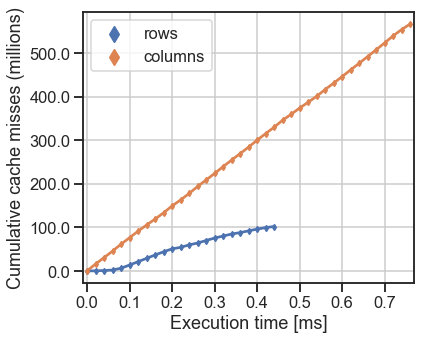

In [47]:
plot_trace(cm_reorder_df, 'cm', 'cm_reorder', ['rows', 'columns'])

## Comparator

In [48]:
cm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'cm', 20000000)

rows: 92
max time: 760000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


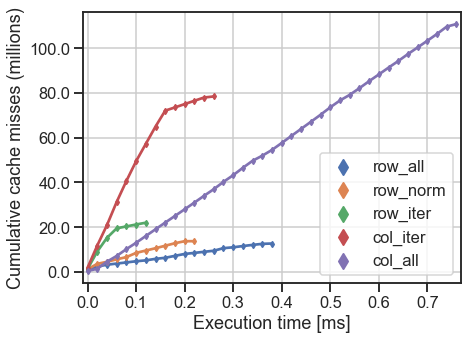

In [49]:
plot_trace(cm_comparator_df, 'cm', 'cm_comparator')

In [50]:
bm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'bm', 20000000)

rows: 92
max time: 760000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


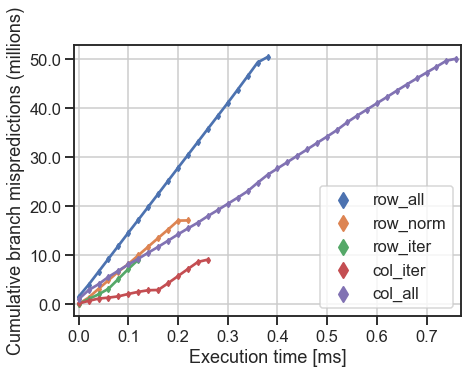

In [51]:
plot_trace(bm_comparator_df, 'bm', 'bm_comparator')

## Sort

In [52]:
cm_sort_df = process_trace_csv(con, 'results/trace_sort.csv', 'cm', 7500000)

rows: 51
max time: 202500000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


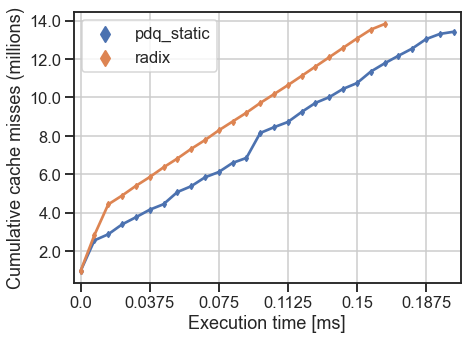

In [53]:
plot_trace(cm_sort_df, 'cm', 'cm_sort')

In [54]:
bm_sort_df = process_trace_csv(con, 'results/trace_sort.csv', 'bm', 7500000)

rows: 51
max time: 202500000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


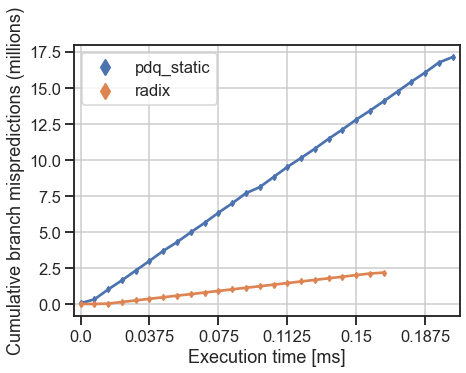

In [55]:
plot_trace(bm_sort_df, 'bm', 'bm_sort')

## Key Merge

In [56]:
cm_merge_key_df = process_trace_csv(con, 'results/trace_merge_key.csv', 'cm', 5000000)

rows: 25
max time: 100000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


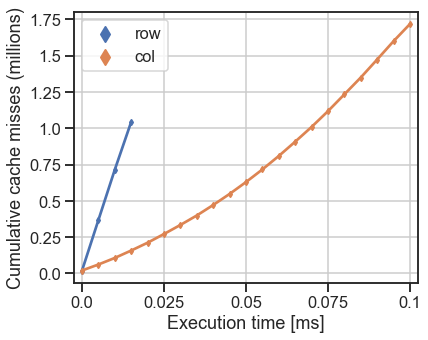

In [57]:
plot_trace(cm_merge_key_df, 'cm', 'cm_merge_key')

In [58]:
bm_merge_key_df = process_trace_csv(con, 'results/trace_merge_key.csv', 'bm', 5000000)

rows: 25
max time: 100000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


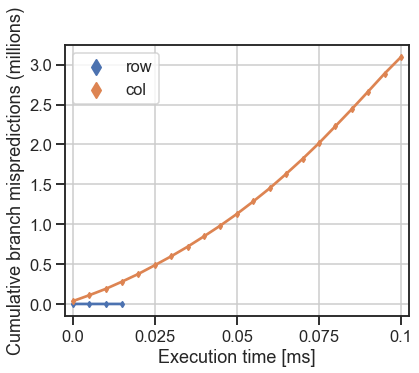

In [59]:
plot_trace(bm_merge_key_df, 'bm', 'bm_merge_key')

## Payload Merge

In [60]:
cm_merge_payload_df = process_trace_csv(con, 'results/trace_merge_payload.csv', 'cm', 10000000)

rows: 61
max time: 2220000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


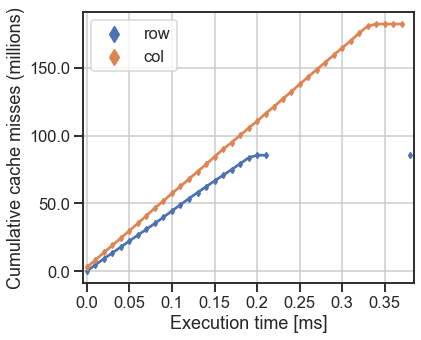

In [61]:
plot_trace(cm_merge_payload_df, 'cm', 'cm_merge_payload')

In [62]:
bm_merge_payload_df = process_trace_csv(con, 'results/trace_merge_payload.csv', 'bm', 10000000)

rows: 61
max time: 2220000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


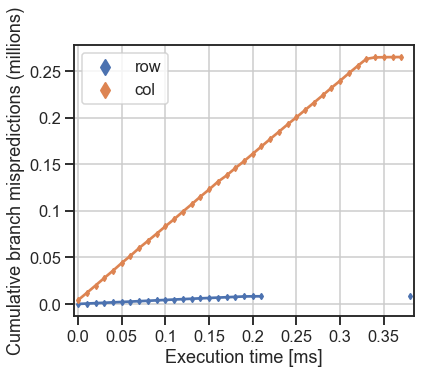

In [63]:
plot_trace(bm_merge_payload_df, 'bm', 'bm_merge_payload')

# Templating ...

In [64]:
for i in range(1, 257):
    print(f'\tcase {i}:')
    print(f'\t\treturn memcmp_fixed<{i}>(str1, str2);')

	case 1:
		return memcmp_fixed<1>(str1, str2);
	case 2:
		return memcmp_fixed<2>(str1, str2);
	case 3:
		return memcmp_fixed<3>(str1, str2);
	case 4:
		return memcmp_fixed<4>(str1, str2);
	case 5:
		return memcmp_fixed<5>(str1, str2);
	case 6:
		return memcmp_fixed<6>(str1, str2);
	case 7:
		return memcmp_fixed<7>(str1, str2);
	case 8:
		return memcmp_fixed<8>(str1, str2);
	case 9:
		return memcmp_fixed<9>(str1, str2);
	case 10:
		return memcmp_fixed<10>(str1, str2);
	case 11:
		return memcmp_fixed<11>(str1, str2);
	case 12:
		return memcmp_fixed<12>(str1, str2);
	case 13:
		return memcmp_fixed<13>(str1, str2);
	case 14:
		return memcmp_fixed<14>(str1, str2);
	case 15:
		return memcmp_fixed<15>(str1, str2);
	case 16:
		return memcmp_fixed<16>(str1, str2);
	case 17:
		return memcmp_fixed<17>(str1, str2);
	case 18:
		return memcmp_fixed<18>(str1, str2);
	case 19:
		return memcmp_fixed<19>(str1, str2);
	case 20:
		return memcmp_fixed<20>(str1, str2);
	case 21:
		return memcmp_fixed<21>(st

In [65]:
for i in range(1, 257):
    print(f'\tcase {i}:')
    print(f'\t\treturn MemcpyFixed<{i}>(dest, src);')

	case 1:
		return MemcpyFixed<1>(dest, src);
	case 2:
		return MemcpyFixed<2>(dest, src);
	case 3:
		return MemcpyFixed<3>(dest, src);
	case 4:
		return MemcpyFixed<4>(dest, src);
	case 5:
		return MemcpyFixed<5>(dest, src);
	case 6:
		return MemcpyFixed<6>(dest, src);
	case 7:
		return MemcpyFixed<7>(dest, src);
	case 8:
		return MemcpyFixed<8>(dest, src);
	case 9:
		return MemcpyFixed<9>(dest, src);
	case 10:
		return MemcpyFixed<10>(dest, src);
	case 11:
		return MemcpyFixed<11>(dest, src);
	case 12:
		return MemcpyFixed<12>(dest, src);
	case 13:
		return MemcpyFixed<13>(dest, src);
	case 14:
		return MemcpyFixed<14>(dest, src);
	case 15:
		return MemcpyFixed<15>(dest, src);
	case 16:
		return MemcpyFixed<16>(dest, src);
	case 17:
		return MemcpyFixed<17>(dest, src);
	case 18:
		return MemcpyFixed<18>(dest, src);
	case 19:
		return MemcpyFixed<19>(dest, src);
	case 20:
		return MemcpyFixed<20>(dest, src);
	case 21:
		return MemcpyFixed<21>(dest, src);
	case 22:
		return MemcpyFixed<